# Medicare Fraud Detection

### Data 698: Data Science Research Project - Spring 2019

### Student: Chunhui Zhu

Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2016.csv: https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/utc4-f9xp

LEIE2019.csv: https://oig.hhs.gov/exclusions/exclusions_list.asp

## Continouse from Part IV

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as plt
from matplotlib import pyplot as plt

import pickle
from sklearn.model_selection import train_test_split

import seaborn as sns
%matplotlib inline
from sklearn import preprocessing

from sklearn import metrics

### Apply ML in Developed Data Set 

devdata_topickle(df_clean2016_map_dev,"df_clean2016_map_dev")

devdata_topickle(df_fraud2016_map_dev,"df_fraud2016_map_dev")

In [2]:
df_pkl=open("df_clean2016_map_dev_pickle","rb")
df_clean2016_map_dev=pickle.load(df_pkl)
df_pkl.close()

In [3]:
df_clean2016_map_dev.head()

,npi,type,gender,hcpcs_c,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,avg_allowed_amt,avg_payment_amt,avg_submitted_chrg_amt,city,state,Fraud,diff_line_srvc_cnt,diff_bene_day_srvc_cnt,diff_avg_submitted_chrg_amt
0,1003000126,0.0,M,99217,23.0,23.0,23.0,72.680000,54.502609,328.000000,3,2,0,-128.793615,-115.933584,166.338604
1,1003000126,0.0,M,99219,18.0,18.0,18.0,135.850000,100.958889,614.000000,3,2,0,-133.793615,-120.933584,452.338604
2,1003000126,0.0,M,99221,59.0,58.0,59.0,101.365085,79.469661,333.288136,3,2,0,-92.793615,-79.933584,171.626740
3,1003000126,0.0,M,99222,132.0,130.0,132.0,139.010455,107.933409,356.492424,3,2,0,-19.793615,-6.933584,194.831028
4,1003000126,0.0,M,99223,220.0,215.0,220.0,205.185955,157.908955,631.186364,3,2,0,68.206385,81.066416,469.524968


## Prepare for Training set and Test set

### Use 2012-2015 as training data set, 2016 as testing data set

In [4]:
#example pickle name df13_pickle
def loaddf (name):
    df_pkl=open(str(name),"rb")
    df=pickle.load(df_pkl)
    print("The number of rows in data set "+str(name) + " is " + str(len(df)) + ".")
    df_pkl.close()

    return (df)

In [5]:
df_clean2016_map_dev = loaddf("df_clean2016_map_dev_pickle")
df_clean2015_map_dev = loaddf("df_clean2015_map_dev_pickle")
df_clean2014_map_dev = loaddf("df_clean2014_map_dev_pickle")
df_clean2013_map_dev = loaddf("df_clean2013_map_dev_pickle")
df_clean2012_map_dev = loaddf("df_clean2012_map_dev_pickle")

df_fraud2016_map_dev = loaddf("df_fraud2016_map_dev_pickle")
df_fraud2015_map_dev = loaddf("df_fraud2015_map_dev_pickle")
df_fraud2014_map_dev = loaddf("df_fraud2014_map_dev_pickle")
df_fraud2013_map_dev = loaddf("df_fraud2013_map_dev_pickle")
df_fraud2012_map_dev = loaddf("df_fraud2012_map_dev_pickle")

The number of rows in data set df_clean2016_map_dev_pickle is 8616830.
The number of rows in data set df_clean2015_map_dev_pickle is 8614233.
The number of rows in data set df_clean2014_map_dev_pickle is 8518795.
The number of rows in data set df_clean2013_map_dev_pickle is 8492184.
The number of rows in data set df_clean2012_map_dev_pickle is 8394058.
The number of rows in data set df_fraud2016_map_dev_pickle is 4785.
The number of rows in data set df_fraud2015_map_dev_pickle is 4785.
The number of rows in data set df_fraud2014_map_dev_pickle is 7502.
The number of rows in data set df_fraud2013_map_dev_pickle is 10195.
The number of rows in data set df_fraud2012_map_dev_pickle is 13012.


In [6]:
df_clean2012to2015_devlist= [df_clean2015_map_dev,df_clean2014_map_dev,df_clean2013_map_dev,df_clean2012_map_dev]
df_clean2012to2015_map_dev=pd.concat(df_clean2012to2015_devlist)
print(len(df_clean2012to2015_map_dev))

34019270


In [7]:
df_fraud2012to2015_devlist= [df_fraud2015_map_dev,df_fraud2014_map_dev,df_fraud2013_map_dev,df_fraud2012_map_dev]
df_fraud2012to2015_map_dev=pd.concat(df_fraud2012to2015_devlist)
print(len(df_fraud2012to2015_map_dev))

35494


### Exclude 2016 sampling data from 2012-2015 training set

#### Ended in 2015, there is unkonw for the fraud in 2016. I exclusive the 2016 fraud from df_fraud2012to2015_1 data set.

In [8]:
df_fraud2012to2015_map_dev_only=df_fraud2012to2015_map_dev[~df_fraud2012to2015_map_dev.npi.isin(df_fraud2016_map_dev.npi.unique())]
len(df_fraud2012to2015_map_dev_only)

12287

In [9]:
df_2012to2015_map_dev=pd.concat([df_fraud2012to2015_map_dev_only,df_clean2012to2015_map_dev],axis=0)
len(df_2012to2015_map_dev)

34031557

In [10]:
df_2012to2015_map_dev.columns

Index(['npi', 'type', 'gender', 'hcpcs_c', 'line_srvc_cnt', 'bene_unique_cnt',
       'bene_day_srvc_cnt', 'avg_allowed_amt', 'avg_payment_amt',
       'avg_submitted_chrg_amt', 'city', 'state', 'Fraud',
       'diff_line_srvc_cnt', 'diff_bene_day_srvc_cnt',
       'diff_avg_submitted_chrg_amt'],
      dtype='object')

### Ramdom Shuffle all rows using sample()

#### Random sampling 1 million data from 2016 as test data, and exclusive them from training data set

In [11]:
df_2016_map_dev=pd.concat([df_fraud2016_map_dev,df_clean2016_map_dev],axis=0)
df_2016_map_dev_shuffle=df_2016_map_dev.sample( frac = 1 )
len(df_2016_map_dev)

8621615

In [12]:
#random sampling 1 Million non-fraud ID from 
test_2016_map_dev_shuffle= df_2016_map_dev.sample(1000000, replace=True)

In [13]:
df_2012to2015_map_dev_only=df_2012to2015_map_dev[~df_2012to2015_map_dev.npi.isin(test_2016_map_dev_shuffle.npi.unique())]
len(df_2012to2015_map_dev_only)

8854569

In [14]:
train_2012to2015_map_dev_only_shuffle=df_2012to2015_map_dev_only.sample( frac = 1 )

In [15]:
train_2012to2015_map_dev_only_shuffle.columns

Index(['npi', 'type', 'gender', 'hcpcs_c', 'line_srvc_cnt', 'bene_unique_cnt',
       'bene_day_srvc_cnt', 'avg_allowed_amt', 'avg_payment_amt',
       'avg_submitted_chrg_amt', 'city', 'state', 'Fraud',
       'diff_line_srvc_cnt', 'diff_bene_day_srvc_cnt',
       'diff_avg_submitted_chrg_amt'],
      dtype='object')

In [16]:
test_2016_map_dev_shuffle.columns

Index(['npi', 'type', 'gender', 'hcpcs_c', 'line_srvc_cnt', 'bene_unique_cnt',
       'bene_day_srvc_cnt', 'avg_allowed_amt', 'avg_payment_amt',
       'avg_submitted_chrg_amt', 'city', 'state', 'Fraud',
       'diff_line_srvc_cnt', 'diff_bene_day_srvc_cnt',
       'diff_avg_submitted_chrg_amt'],
      dtype='object')

#### Drop "npi" & "hcpcs_c"

In [17]:
train_2012to2015_map_dev_only_shuffle = train_2012to2015_map_dev_only_shuffle.drop(['npi', 'hcpcs_c','gender','bene_unique_cnt','avg_allowed_amt', 'avg_payment_amt'],axis=1)
test_2016_map_dev_shuffle = test_2016_map_dev_shuffle.drop(['npi', 'hcpcs_c','gender','bene_unique_cnt','avg_allowed_amt', 'avg_payment_amt'],axis=1)

Fraud 0: 8842282
Fraud 1: 12287
Proportion: 719.65 : 1


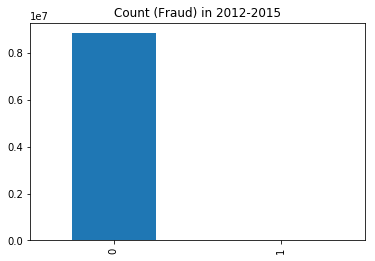

In [18]:
fraud_count = train_2012to2015_map_dev_only_shuffle.Fraud.value_counts()
print('Fraud 0:', fraud_count[0])
print('Fraud 1:', fraud_count[1])
print('Proportion:', round(fraud_count[0] / fraud_count[1], 2), ': 1')

fraud_count.plot(kind='bar', title='Count (Fraud) in 2012-2015');

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

In [20]:
df_x_train_shuffle = train_2012to2015_map_dev_only_shuffle.drop(columns=['Fraud'])

In [21]:
df_y_train_shuffle = train_2012to2015_map_dev_only_shuffle.Fraud

In [22]:
# fit the model with data
logreg.fit(df_x_train_shuffle,df_y_train_shuffle)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
df_x_test_shuffle=test_2016_map_dev_shuffle.drop(['Fraud'],axis=1)
df_y_test_shuffle=test_2016_map_dev_shuffle.Fraud

In [24]:
pred_y=logreg.predict(df_x_test_shuffle)

In [25]:
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y)
cnf_matrix

array([[999469,      0],
       [   531,      0]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

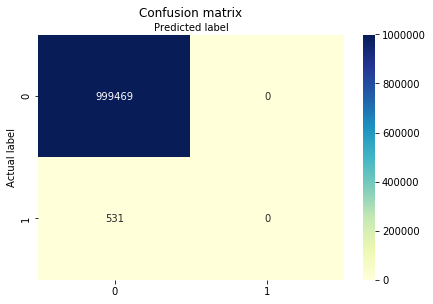

In [26]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y))

Accuracy: 0.999469


C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.0
Recall: 0.0


### ROC Curve

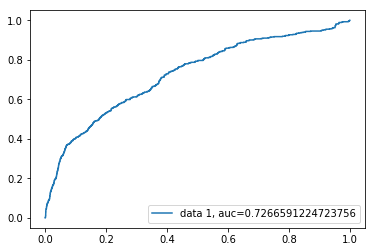

In [28]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Imbalanced-learn module - Over Sampling SMOTE (ratio =1.0)

In [29]:
from imblearn.over_sampling import SMOTE

In [30]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_sm, y_train_sm = sm.fit_sample(df_x_test_shuffle,df_y_test_shuffle)

In [31]:
df_y_train_sm_resample=pd.DataFrame(y_train_sm)
df_x_train_sm_resample=pd.DataFrame(x_train_sm)
aftersample_2012to2015=pd.concat([df_x_train_sm_resample, df_y_train_sm_resample],axis=1)

In [32]:
aftersample_2012to2015.head()

,0,1,2,3,4,5,6,7,8,0
0,0.0,622.0,622.0,140.000000,4.0,4.0,490.438935,508.346102,-30.351692,0
1,2.0,30.0,30.0,351.066667,4.0,4.0,-116.400389,-101.067305,-64.477720,0
2,3.0,125.0,125.0,224.000000,4.0,0.0,-1048.285949,-57.867339,-49.554222,0
3,0.0,28.0,28.0,219.000000,4.0,1.0,-83.345505,-71.936406,79.164403,0
4,3.0,25.0,25.0,854.810000,3.0,2.0,-55.307411,-43.858285,551.065758,0


Fraud 0: 999469
Fraud 1: 999469
Proportion: 1.0 : 1


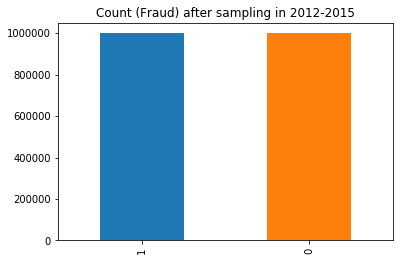

In [33]:
fraud_count_aftersample = aftersample_2012to2015.iloc[:,-1].value_counts()
print('Fraud 0:', fraud_count_aftersample [0])
print('Fraud 1:', fraud_count_aftersample [1])
print('Proportion:', round(fraud_count_aftersample [0] / fraud_count_aftersample [1], 2), ': 1')

fraud_count_aftersample.plot(kind='bar', title='Count (Fraud) after sampling in 2012-2015');

In [34]:
aftersample_2012to2015.columns=['type','line_srvc_cnt','bene_day_srvc_cnt','avg_submitted_chrg_amt','city','state','diff_line_srvc_cnt', 'diff_bene_day_srvc_cnt',
       'diff_avg_submitted_chrg_amt','Fraud']

In [32]:
aftersample_2012to2015.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,Fraud
0,1.0,62.0,54.0,89.000000,4.0,0.0,0
1,4.0,62.0,62.0,325.300000,4.0,0.0,0
2,4.0,12.0,12.0,22.833333,4.0,0.0,0
3,4.0,23.0,23.0,217.000000,3.0,1.0,0
4,2.0,23.0,23.0,90.000000,4.0,0.0,0


## Logistic Regression using Oversampls

In [35]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

In [36]:
# fit the model with data
logreg.fit(df_x_train_sm_resample,df_y_train_sm_resample)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
pred_y_oversample=logreg.predict(df_x_test_shuffle)

In [38]:
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y_oversample)
cnf_matrix

array([[770412, 229057],
       [   186,    345]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

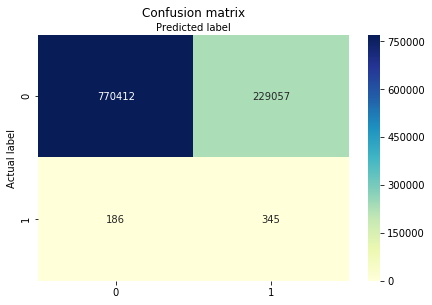

In [39]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [40]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y_oversample))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y_oversample))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y_oversample))

Accuracy: 0.770757
Precision: 0.001503910166432725
Recall: 0.6497175141242938


### ROC Curve for oversample

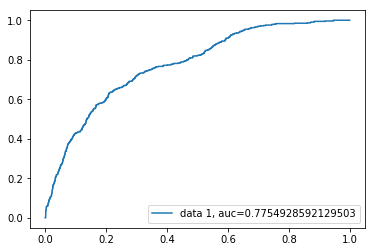

In [41]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Over Sampling SMOTE (ratio =0.8)

In [42]:
sm = SMOTE(random_state=12, ratio = 0.8)
x_train_sm, y_train_sm = sm.fit_sample(df_x_test_shuffle,df_y_test_shuffle)

In [43]:
df_y_train_sm_resample=pd.DataFrame(y_train_sm)
df_x_train_sm_resample=pd.DataFrame(x_train_sm)
aftersample_2012to2015=pd.concat([df_x_train_sm_resample, df_y_train_sm_resample],axis=1)

Fraud 0: 999469
Fraud 1: 799575
Proportion: 1.25 : 1


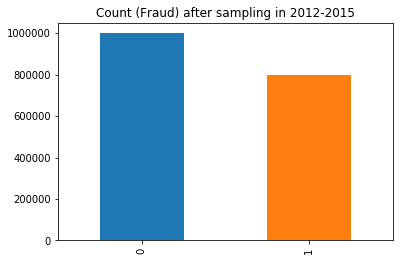

In [44]:
fraud_count_aftersample = aftersample_2012to2015.iloc[:,-1].value_counts()
print('Fraud 0:', fraud_count_aftersample [0])
print('Fraud 1:', fraud_count_aftersample [1])
print('Proportion:', round(fraud_count_aftersample [0] / fraud_count_aftersample [1], 2), ': 1')

fraud_count_aftersample.plot(kind='bar', title='Count (Fraud) after sampling in 2012-2015');

In [46]:
aftersample_2012to2015.columns=['type','line_srvc_cnt','bene_day_srvc_cnt','avg_submitted_chrg_amt','city','state','diff_line_srvc_cnt', 'diff_bene_day_srvc_cnt',
       'diff_avg_submitted_chrg_amt','Fraud']
aftersample_2012to2015.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,diff_line_srvc_cnt,diff_bene_day_srvc_cnt,diff_avg_submitted_chrg_amt,Fraud
0,0.0,622.0,622.0,140.000000,4.0,4.0,490.438935,508.346102,-30.351692,0
1,2.0,30.0,30.0,351.066667,4.0,4.0,-116.400389,-101.067305,-64.477720,0
2,3.0,125.0,125.0,224.000000,4.0,0.0,-1048.285949,-57.867339,-49.554222,0
3,0.0,28.0,28.0,219.000000,4.0,1.0,-83.345505,-71.936406,79.164403,0
4,3.0,25.0,25.0,854.810000,3.0,2.0,-55.307411,-43.858285,551.065758,0


In [47]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
logreg.fit(df_x_train_sm_resample,df_y_train_sm_resample)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
pred_y_oversample=logreg.predict(df_x_test_shuffle)
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y_oversample)
cnf_matrix

array([[809216, 190253],
       [   220,    311]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

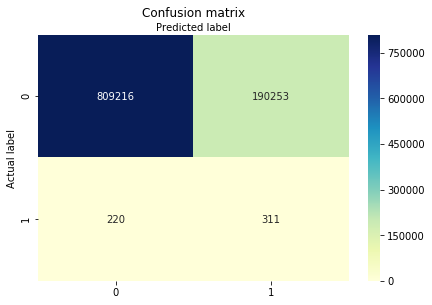

In [49]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [50]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y_oversample))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y_oversample))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y_oversample))

Accuracy: 0.809527
Precision: 0.0016319976490837725
Recall: 0.5856873822975518


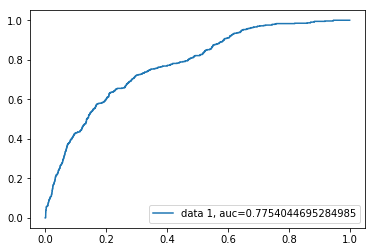

In [51]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Over Sampling SMOTE (ratio =0.5)

In [52]:
sm = SMOTE(random_state=12, ratio = 0.5)
x_train_sm, y_train_sm = sm.fit_sample(df_x_test_shuffle,df_y_test_shuffle)

In [53]:
df_y_train_sm_resample=pd.DataFrame(y_train_sm)
df_x_train_sm_resample=pd.DataFrame(x_train_sm)
aftersample_2012to2015=pd.concat([df_x_train_sm_resample, df_y_train_sm_resample],axis=1)

Fraud 0: 999469
Fraud 1: 499734
Proportion: 2.0 : 1


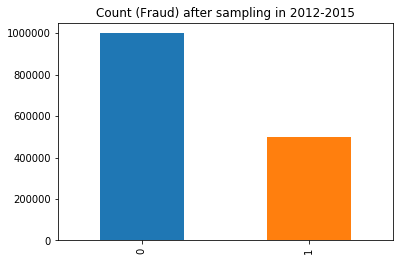

In [54]:
fraud_count_aftersample = aftersample_2012to2015.iloc[:,-1].value_counts()
print('Fraud 0:', fraud_count_aftersample [0])
print('Fraud 1:', fraud_count_aftersample [1])
print('Proportion:', round(fraud_count_aftersample [0] / fraud_count_aftersample [1], 2), ': 1')

fraud_count_aftersample.plot(kind='bar', title='Count (Fraud) after sampling in 2012-2015');

In [55]:
aftersample_2012to2015.columns=['type','line_srvc_cnt','bene_day_srvc_cnt','avg_submitted_chrg_amt','city','state','diff_line_srvc_cnt', 'diff_bene_day_srvc_cnt',
       'diff_avg_submitted_chrg_amt','Fraud']
aftersample_2012to2015.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,diff_line_srvc_cnt,diff_bene_day_srvc_cnt,diff_avg_submitted_chrg_amt,Fraud
0,0.0,622.0,622.0,140.000000,4.0,4.0,490.438935,508.346102,-30.351692,0
1,2.0,30.0,30.0,351.066667,4.0,4.0,-116.400389,-101.067305,-64.477720,0
2,3.0,125.0,125.0,224.000000,4.0,0.0,-1048.285949,-57.867339,-49.554222,0
3,0.0,28.0,28.0,219.000000,4.0,1.0,-83.345505,-71.936406,79.164403,0
4,3.0,25.0,25.0,854.810000,3.0,2.0,-55.307411,-43.858285,551.065758,0


In [56]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
logreg.fit(df_x_train_sm_resample,df_y_train_sm_resample)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [57]:
pred_y_oversample=logreg.predict(df_x_test_shuffle)
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y_oversample)
cnf_matrix

array([[869433, 130036],
       [   278,    253]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

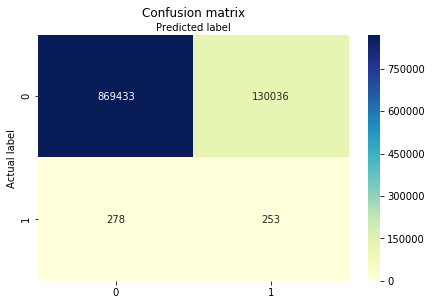

In [58]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [59]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y_oversample))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y_oversample))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y_oversample))

Accuracy: 0.869686
Precision: 0.0019418369931460061
Recall: 0.4764595103578154


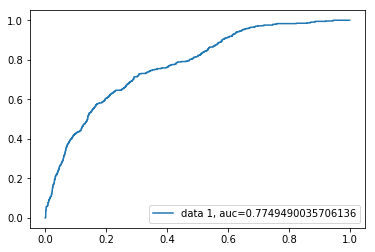

In [60]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Save training and testing data sets in pickles for the other ML

In [61]:
train_x_pkl=open(str("train_x_addcolumns_pickle"),"wb")
pickle.dump(df_x_train_shuffle,train_x_pkl)
train_x_pkl.close()

In [62]:
train_y_pkl=open(str("train_y_addcolumns_dev_pickle"),"wb")
pickle.dump(df_x_train_shuffle,train_y_pkl)
train_y_pkl.close()

In [63]:
test_x_pkl=open(str("test_x_addcolumns_pickle"),"wb")
pickle.dump(df_x_test_shuffle,test_x_pkl)
test_x_pkl.close()

In [64]:
test_y_pkl=open(str("test_y_addcolumns_pickle"),"wb")
pickle.dump(df_y_test_shuffle,test_y_pkl)
test_y_pkl.close()

## Reference

1. LogisticRegression()
https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

2. Resampling strategies for imbalanced datasets
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets